# Visualize Max & Min Ratio Transitions

In [51]:
import os
import tensorflow as tf
import collections
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
os.chdir('/Users/gbg141/dopamine')
from dopamine.replay_memory import cs_replay_buffer
from dopamine.replay_memory.circular_replay_buffer import ReplayElement
from dopamine.discrete_domains import checkpointer

In [22]:
sess = tf.InteractiveSession()

/Users/gbg141/dopamine/dopamine-env/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [31]:
def load_replay_buffer(log_directory=None, game=None, extra_dir=None):
    buffer = cs_replay_buffer.WrappedCSReplayBuffer(
                observation_shape=(84,84),
                stack_size=4,
                replay_capacity=10000000,
                extra_storage_types=[ReplayElement('beginning', (), np.bool)])
    
    checkpoint_file_prefix = 'ckpt'
    if log_directory:
        checkpoint_dir = os.path.join(log_directory, 'checkpoints')
    else:
        log_directory = os.path.join('./logs', game + extra_dir)
        checkpoint_dir = os.path.join(log_directory, 'checkpoints')
    #my_checkpointer = checkpointer.Checkpointer(checkpoint_dir, checkpoint_file_prefix)
    latest_checkpoint_version = checkpointer.get_latest_checkpoint_number(checkpoint_dir)
    
    buffer.load(checkpoint_dir, latest_checkpoint_version)
    
    return buffer

In [150]:
def get_transitions_by_indices(indices):
    batch_size=len(indices)
    transition_batch = buffer.memory.sample_transition_batch(batch_size=batch_size, indices=indices)
    transition_type = buffer.memory.get_transition_elements()
    
    transitions = []
    for i, index in enumerate(indices):
        transition = collections.OrderedDict()
        transition['index'] = index
        for element, element_type in zip(transition_batch, transition_type):
            transition[element_type.name] = element[i]
        transitions.append(transition)

    return transitions

def sort_transitions_by_ratio(transitions, reverse=True):
    transitions.sort(key= lambda x: x['sampling_probabilities'], reverse=reverse)
    
def keep_K_max_ratio_transitions(transitions):
    sort_transitions_by_ratio(transitions)
    return transitions[:min(K,len(transitions))]

def keep_K_min_ratio_transitions(transitions):
    sort_transitions_by_ratio(transitions, reverse=False)
    return transitions[:min(K,len(transitions))]

def get_max_and_min_transitions(min_idx, max_idx, batch_size):
    max_transitions = list()
    min_transitions = list()

    idx = min_idx
    while idx < max_index:
        indices = [i for i in range(idx, min(batch_size + idx, max_idx))]
        idx = idx + batch_size

        transitions = get_transitions_by_indices(indices)

        max_transitions = keep_K_max_ratio_transitions(max_transitions + transitions)

        min_transitions = keep_K_min_ratio_transitions(min_transitions + transitions)
        
    return max_transitions, min_transitions

def plot_transitions(transitions, columns=4, rows=4):
    fig = plt.figure(figsize=(14, 14))
    # ax enables access to manipulate each of subplots
    ax = []

    for i in range(columns*rows):
        img = transitions[i]['state'][:,:,3]
        # create subplot and append to ax
        ax.append( fig.add_subplot(rows, columns, i+1) )
        ax[-1].set_title("c:"+str(transitions[i]['sampling_probabilities']))  # set title
        plt.axis('off')
        plt.imshow(img)
    
    plt.show()  # finally, render the plot
    plt.close()

In [32]:
buffer = load_replay_buffer('./logs/loglog0025100101n02')

INFO:tensorflow:Creating a OutOfGraphPrioritizedReplayBuffer replay memory with the following parameters:
INFO:tensorflow:	 observation_shape: (84, 84)
INFO:tensorflow:	 observation_dtype: <class 'numpy.uint8'>
INFO:tensorflow:	 stack_size: 4
INFO:tensorflow:	 replay_capacity: 10000000
INFO:tensorflow:	 batch_size: 32
INFO:tensorflow:	 update_horizon: 1
INFO:tensorflow:	 gamma: 0.990000


In [147]:
K = 50
batch_size = 100
min_index = 0
max_index = 20000#buffer.memory.add_count-1

In [148]:
max_transitions, min_transitions = get_max_and_min_transitions(
                                        min_index, max_index, batch_size)

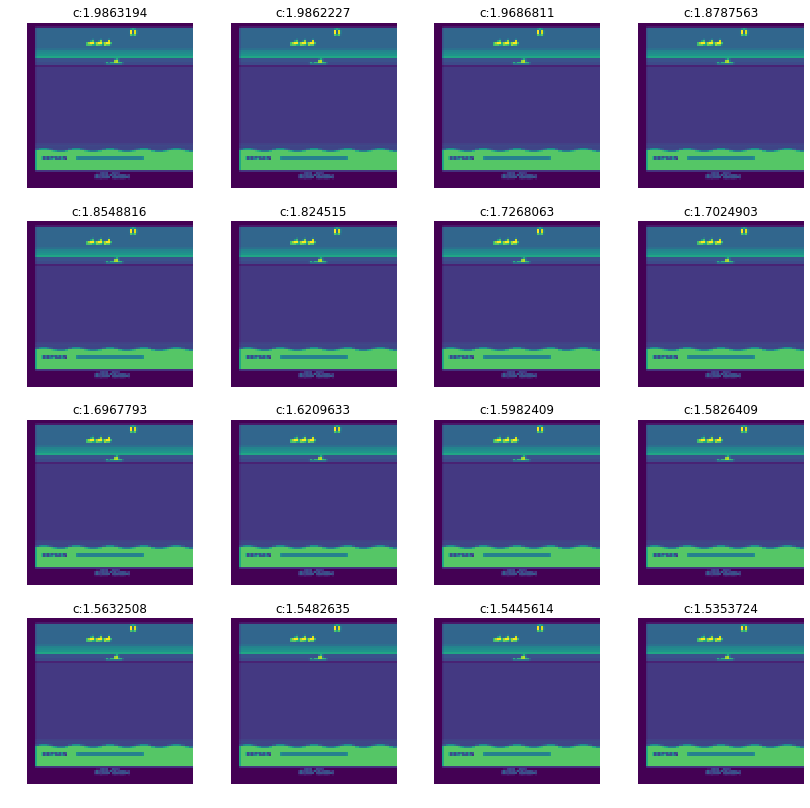

In [149]:
plot_transitions(max_transitions)

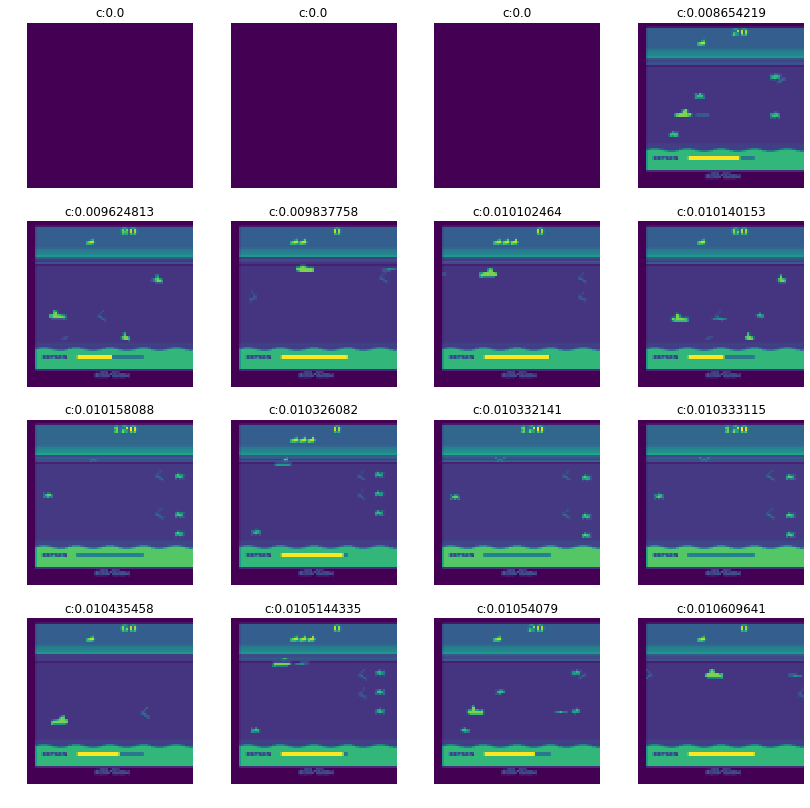

In [141]:
plot_transitions(min_transitions)